## Parte 0

In [1]:
"""
Il datataset new_weather.csv contiene dati che descrivono alcuni indicatori meteorologici di
Seattle (temperatura, pressione atmosferica, punto di rugiada, ...). I dati vengono codificati
giornalmente e per ogni codifica viene inserito il valore minimo, massimo e la media del valore
dell’indicatore. Il dataset presenta poi un campo (“Event”) che evidenzia se in quella data c’è
stato un fenomeno atmosferico.
Scopo dell’esercizio è predire se in una certa data si è avuto un evento atmosferico
indipendentemente dalla sua natura.
"""
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler)
from sklearn.metrics import (accuracy_score, confusion_matrix)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import (SelectKBest, chi2)

## Parte 1

### Punto 1.1

In [2]:
"""
    Caricare il dataset e denominarlo con una variabile chiamata “dataset”
"""
dataset = pd.read_csv('new_weather.csv')
print('Dataset:\n {}'.format(dataset.head()))
dataset.head()
print('Columns name:\n {}'.format(dataset.columns.values))

Dataset:
          Date  Max_Temperature_F  Mean_Temperature_F  Min_TemperatureF  \
0  2014-10-13                 71                62.0                54   
1  2014-10-14                 63                59.0                55   
2  2014-10-15                 62                58.0                54   
3  2014-10-16                 71                61.0                52   
4  2014-10-17                 64                60.0                57   

   Max_Dew_Point_F  MeanDew_Point_F  Min_Dewpoint_F  Max_Humidity  \
0               55               51              46            87   
1               52               51              50            88   
2               53               50              46            87   
3               49               46              42            83   
4               55               51              41            87   

   Mean_Humidity  Min_Humidity  ...   Min_Sea_Level_Pressure_In  \
0             68            46  ...                       29.65

### Punto 1.2

In [3]:
"""
    Quante sono le istanze contenute nel dataset? 
    
    Il dataset è completo (cioè per ogni istanza tutti i valori di attributo sono sempre specificati 
    – non esistono “missing values”)?
    
    Se esistono indicare quali sono e se l’assenza di questi valori pregiudica la possibilità di
    predire quanto richiesto (punti 1).
    
    Il dataset è bilanciato per quanto riguarda la classe da predire? 
"""
num_istances = dataset.shape[0]
print('Numero di istanze: {}'.format(num_istances))

num_columns_NaN = dataset.isnull().sum() # Restituisce il valore di NaN per ogni colonna
num_NaN = num_columns_NaN.sum() # Sommo tutti i valori di NaN di ogni colonna
print('Numero di \'missing values\': {}'.format(num_NaN))

bool_NaN = dataset.isnull().values.any()
print('Il dataset contiene valori \'null\': {}'.format(bool_NaN))

idx, idy = np.where(dataset.isnull()) # Restituisce gli indici di riga e di colonna con valori 'NaN'
tuple_NaN = np.column_stack([dataset.index[idx], dataset.columns[idy]])
print('Primi 5 valori:\n {}'.format(tuple_NaN[:5, :]))

print('*' * 100)
num_events = dataset.groupby(['Events']).size().sum()
print('La classe è bilanciata: Numero di eventi {} - Numero di valori mancanti {}'.format(num_events, num_NaN))

Numero di istanze: 689
Numero di 'missing values': 362
Il dataset contiene valori 'null': True
Primi 5 valori:
 [[6 'Events']
 [19 'Events']
 [25 'Events']
 [26 'Events']
 [28 'Events']]
****************************************************************************************************
La classe è bilanciata: Numero di eventi 328 - Numero di valori mancanti 362


### Punto 1.3

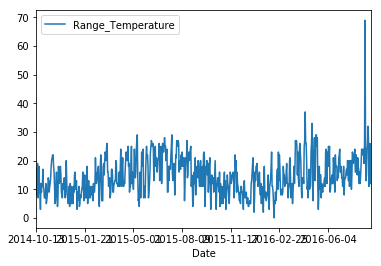

In [4]:
"""
    Creare un nuovo attributo “Range_Temperature” che misuri l’escursione termica giornaliera.
    
    Si osserva qualcosa di particolare nella distribuzione dei valori?
"""
range_temperature = dataset['Max_Temperature_F'] - dataset['Min_TemperatureF']
dataset['Range_Temperature'] = range_temperature
dataset.plot(x = 'Date', y = 'Range_Temperature')
plt.show()

### Punto 1.4

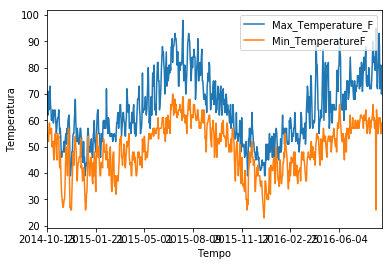

In [5]:
"""
    Rappresentare in un grafico la temperatura massima e la temperatura minima
"""
dataset.plot(x = 'Date', y = ['Max_Temperature_F', 'Min_TemperatureF'])
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.show()

### Punto 1.5

In [6]:
"""
    Quanti eventi atmosferici accadono nel 2015? Come sono distribuiti per tipologie nei mesi?
    Rappresentare con il grafico più opportuno questa distribuzione (punti 2).
"""
eventi_atmosferici = dataset.groupby(['Year', 'Month']).size().unstack()
eventi_2015 = eventi_atmosferici[eventi_atmosferici.index == 2015.0]
eventi_2015

Month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Year,,,,,,,,,,,,
2015.0,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0


## Parte 2 

### Punto 2.1

In [7]:
"""
    Scikit-learn utilizza un array numpy per effettuare le proprie predizioni. Gli elementi
    dell’array numpy devono essere delle stesso data type numerico. E’ necessario pertanto
    trasformare i dati del dataset per renderli utilizzabili con scikit. Creare quindi un nuovo dataset
    dal precedente e trasformare i valori del campo “Events” in 1 / 0 a seconda del fatto che si
    registri o meno un evento.
"""
# Copio il dataset
dataset_new = dataset.copy()

# Modifico i valori delle colonne 'Day', 'Month' e 'Year'
label = LabelEncoder()
dataset_new[['Day', 'Month', 'Year', 'Mean_Temperature_F']] = dataset_new[['Day', 'Month', 'Year', 'Mean_Temperature_F']].apply(label.fit_transform)

# Soluzione brutta ma efficace
dataset_new['Events'] = dataset_new['Events'].fillna(0) # Sostituisco tutti i valori 'nan' con 0
# Sostituisco tutti i valori diversi da 0 con 1
dataset_new['Events'] = np.where(dataset_new['Events'] == 0, 0, 1)
values_01 = dataset_new.groupby(dataset_new['Events']).size()
print('Valori uguali a 1: {}'.format(values_01[1]))
print('Valori uguali a 0: {}'.format(values_01[0]))

Valori uguali a 1: 328
Valori uguali a 0: 361


### Punto 2.2

In [8]:
"""
    Si vuole predire il il fatto che ci sia o meno un evento sulla base degli altri attributi presenti
    nel dataset. Dividere il dataset in modo che 2/3 degli elementi siano contenuti in un nuovo
    dataset “train” e 1/3 nel dataset “test” (punti 1).
    
    Valutare l’accuracy ottenuta con il modello BernoulliNB su entrambi i dataset
    (from sklearn.naive_bayes import BernoulliNB)
"""
X = dataset_new.drop(['Events', 'Date'], axis = 1)
Y = dataset_new['Events']

test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

# Valutazione
model_BNB = BernoulliNB()
model_BNB.fit(X_train, Y_train)
print('Score BernoulliNB: {:.03f}'.format(model_BNB.score(X_test, Y_test)))

Score BernoulliNB: 0.623


### Punto 2.3

In [9]:
"""
    Il valore di accuratezza ottenuto è pari a
"""

print('Accuracy tramite score: {:0.3f}'.format(model_BNB.score(X_test, Y_test)))
y_pred_BNB = model_BNB.predict(X_test)
accuracy_BNB = accuracy_score(Y_test, y_pred_BNB)
print('Accuracy tramite predizione: {:0.3f}'.format(accuracy_BNB))

Accuracy tramite score: 0.623
Accuracy tramite predizione: 0.623


### Punto 2.4

In [10]:
"""
    Cosa si scopre analizzando le confusion matrix?
"""
cf_BNB = confusion_matrix(Y_test, y_pred_BNB)
print('Confusion matrix BernulliNB:\n{}'.format(cf_BNB))

Confusion matrix BernulliNB:
[[110  14]
 [ 72  32]]


### Punto 2.5

In [11]:
"""
    Se si utilizza un modello basato su Decision Tree che valore di accuratezza si ottiene? Cambia
    qualcosa nella confusion matrix?
"""
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, Y_train)
accuracy = model_DT.score(X_test, Y_test)
print('Accurary DecisionTree: {:.3f}'.format(accuracy))

Accurary DecisionTree: 0.794


### Punto 2.6

In [12]:
"""
    Che valore di accuratezza si ottiene con un 10 Fold cross validation e il modello basato su
    Decision Tree? 
    E il modello basato su BernoulliNB?
    
    E’ più affidabile la valutazione fatta con la cross validation o quella fatta con una suddivisione
    arbitraria del dataset in due parti, training set e test set? Per quale motivo?
"""

models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('BNB', BernoulliNB()))

num_folds = 10
scoring = 'accuracy'
names = []
scores = []
for name, model in models:
    cvs = cross_val_score(model, X, Y, cv = num_folds, scoring = scoring)
    names.append(name)
    scores.append(cvs)
    string = "Score {}: {:0.3f}% ({:0.3f}%)".format(name, cvs.mean(), cvs.std())
    print(string)

Score DT: 0.744% (0.083%)
Score BNB: 0.615% (0.150%)


### Punto 2.7

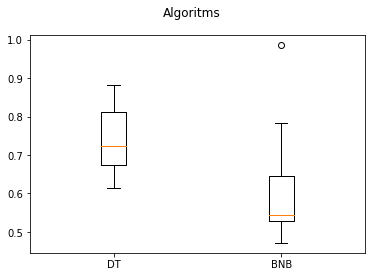

In [13]:
"""
    Provare e confrontare graficamente alcuni algoritmi di machine learning scelti dalle librerie di
    scikit
"""
fig = plt.figure()
fig.suptitle('Algoritms')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()

### Punto 2.8

In [14]:
"""
    Creare un nuovo dataset “reduced” con esclusivamente i valori medi degli indicatori
    atmosferici. Per ogni feature, dividere il range dei valori in 6 gruppi. Sostituire al valore
    originale dell’attributo un numero che va da 1 a 6 e che indica l’appartenenza allo specifico
    gruppo. Valutare l’accuratezza ottenuta con un qualsiasi algoritmo utilizzato in precedenza.
"""
# Copio per evitare problemi nelle future esecuzioni
dataset_reduced = dataset_new.copy()

num_chunks = 6
values_chunks = [1, 2, 3, 4, 5, 6]
# Cambio i valori di tutte le colonne che contengono l'attributo 'Mean'
for columns_name in dataset_reduced.columns:
    if 'Mean' in columns_name:
        # Poiché alcune colonne danno errori uso try-except
        try:
            dataset_reduced[columns_name] = pd.qcut(dataset_reduced[columns_name],
                                            num_chunks, values_chunks)
            break
        except ValueError:
            continue

### Punto 2.9

### Punto 2.10

In [15]:
"""

    Dividere nuovamente il dataset in modo che 3/4 degli elementi siano contenuti in un dataset
    “train” e 1/4 nel dataset “test” (punti 5).
    
    Considerare il Train. Dividerlo in 3 nuovi dataset.
        Month 1,2,3,4 --> dataset1
        Month 5,6,7,8 --> dataset2
        Month 9,10,11,12 --> dataset3
    
    Eliminare l’attributo Month dai 3 dataset di training.
    Eliminare l’attributo Month dal dataset di test
    
    Allenare 3 classificatori di tipo decisionTree con i 3 dataset.
    
    Effettuare la predizione del test con un sistema di votazione: la classe maggiormente predetta
    nei 3 dataset è quella che viene selezionata.
    
    Calcolare l’accuratezza dell’approccio.
"""
# Copio il dataset per evitare futuri problemi
dt = dataset.copy()
# Modifico le colonne 'Day', 'Year' e 'Mean_Temperature_F' perché sono in 'float64' e DecisionTree non 
# riesce a lavorare - Uguale al punto precedente
label = LabelEncoder()
dt[['Day']] = dt[['Day']].apply(label.fit_transform)
dt[['Year']] = dt[['Year']].apply(label.fit_transform)
dt[['Mean_Temperature_F']] = dt[['Mean_Temperature_F']].apply(label.fit_transform)
# Modifico 'Events' per rimuovere i valori 'nan' e convertire gli altri valori con 1
dt['Events'] = dt['Events'].fillna(0)
dt['Events'] = np.where(dt['Events'] == 0, 0, 1)

# Elimino la riga 'Date' perché è in formato String
dt = dt.drop(['Date'], axis = 1)
                              
# Splitto il dataset in 3/4 train e 1/4 test
test_size = 0.25
train, test = train_test_split(dt, test_size = test_size)
# Prendo la colonna da predire dal test
Y_test = test['Events']
test = test.drop(['Month', 'Events'], axis = 1)

# Creo i tre dataset
dataset1 = train[(1 <= train['Month']) & (train['Month'] <= 4)]
dataset2 = train[(5 <= train['Month']) & (train['Month'] <= 8)]
dataset3 = train[(9 <= train['Month']) & (train['Month'] <= 12)]

# Elimino le colonne
dataset1 = dataset1.drop('Month', axis = 1)
dataset2 = dataset2.drop('Month', axis = 1)
dataset3 = dataset3.drop('Month', axis = 1)

# I 3 classificatori di tipo DecisionTree
dt_models = []
dt_models.append(('DecisionTree #1', DecisionTreeClassifier(criterion = 'entropy', splitter = 'random')))
dt_models.append(('DecisionTree #2', DecisionTreeClassifier(max_depth = 5, min_samples_split = 3)))
dt_models.append(('DecisionTree #3', DecisionTreeClassifier(min_samples_leaf = 10, max_features = 8)))

datasets = []
datasets.append(('Dataset #1', dataset1))
datasets.append(('Dataset #2', dataset2))
datasets.append(('Dataset #3', dataset3))

from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(datasets)

scores = []
for name_model, model in dt_models:
    for name_dataset, dataset_n in datasets:
        # Prendo X e Y di training e test
        Y_split = dataset_n['Events']
        X_split = dataset_n.drop(['Events'], axis = 1)
        model.fit(X_split, Y_split)
        y_pred = model.predict(test)
        score = accuracy_score(Y_test, y_pred)
        scores.append((score, name_model, name_dataset))
        string = '{} del {} ha un accuracy di {:.03f}'.format(name_model, name_dataset, score)
        print(string)
        
# Prendo il valore massimo di score
valore_max = max(scores)
print('Il valore massimo si è ottenuto con: {}'.format(valore_max))

DecisionTree #1 del Dataset #1 ha un accuracy di 0.613
DecisionTree #1 del Dataset #2 ha un accuracy di 0.746
DecisionTree #1 del Dataset #3 ha un accuracy di 0.723
DecisionTree #2 del Dataset #1 ha un accuracy di 0.827
DecisionTree #2 del Dataset #2 ha un accuracy di 0.769
DecisionTree #2 del Dataset #3 ha un accuracy di 0.769
DecisionTree #3 del Dataset #1 ha un accuracy di 0.624
DecisionTree #3 del Dataset #2 ha un accuracy di 0.786
DecisionTree #3 del Dataset #3 ha un accuracy di 0.798
Il valore massimo si è ottenuto con: (0.82658959537572252, 'DecisionTree #2', 'Dataset #1')


In [16]:
"""
    Effettuare (e giustificare) una variazione a piacere del dataset e calcolare l’accuratezza
    ottenuta dal nuovo dataset
"""
dt_z = dataset.copy()

X_z = dt_z.drop('Events', axis = 1)
X_z = X_z.fillna(1)

Y_z = dt_z['Events']
Y_z = Y_z.fillna(0)
Y_z = np.where(Y_z == 0, 0, 1)

# Creo le colonne get_dummies per l'anno
dummy_year = pd.get_dummies(X_z['Year'])
X_z = pd.concat([X_z, dummy_year], axis = 1)
X_z = X_z.drop('Year', axis = 1)
# Aggiungo una colonna colonna 'Day_Z' se maggiore di 15 assegno 1 altrimenti 0
X_z['Day'] = np.where(X_z['Day'] > 15, 1 , 0)
# Aggiungo una colonna 'Season' con i valori 1, 2, 3, 4
seasons = 8
labels_season = [1, 2, 3, 4, 5, 6, 7, 8]
X_z['Seasons'] = pd.qcut(X_z['Month'], seasons, labels_season)
# Elimino la colonna 'Date'
X_z = X_z.drop(['Date'], axis = 1)
# Creo una nuova colonna Temperatura data dalla temperatura massimo meno la minima diviso la media
X_z['Temperatura_Z'] = (X_z['Max_Temperature_F'] - X_z['Min_TemperatureF']) / X_z['Mean_Temperature_F']
X_z['Visibility_Milel_Z'] = (X_z['Max_Visibility_Miles'] - X_z['Min_Visibility_Miles']) / X_z['Mean_Visibility_Miles']
X_z['Humidity_Z'] = (X_z['Max_Humidity'] - X_z['Min_Humidity'])
# Aggiungo una colonna colonna 'Mean_T' nella quale se maggiore la temperatura media è maggiore della media
# assegno 1, altrimenti 0
mean_temp = X_z['Mean_Temperature_F'].mean()
mean_max_temp = X_z['Max_Temperature_F'].mean()
mean_min_temp = X_z['Min_TemperatureF'].mean()
mean_of_mean = (mean_max_temp - mean_min_temp) / mean_temp
X_z['Mean_T'] = np.where(X_z['Mean_Temperature_F'] < mean_of_mean, 0, 1)



# Selezione le features più importanti
selector = SelectKBest(chi2, 10)
X_features = selector.fit_transform(X_z, Y_z)


X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_z, test_size = 0.2, random_state = 111)
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, Y_train)
y_pred = model_DT.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy modello Z: {:.03f}'.format(accuracy))
cf_z = confusion_matrix(Y_test, y_pred)
print('Confusion matrix Z:\n{}'.format(cf_z))

Accuracy modello Z: 0.761
Confusion matrix Z:
[[61 13]
 [20 44]]
